<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.plotting import plot_efficient_frontier
from pypfopt import risk_models
from pypfopt import expected_returns
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.config import config
from finrl.trade.backtest import backtest_stats, backtest_plot, get_daily_return, get_baseline, convert_daily_return_to_pyfolio_ts
from finrl.preprocessing.data import data_split

import seaborn as sns
sns.set_theme(style='darkgrid')
plt.rcParams['figure.figsize']=(13,8)

/usr/local/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [3]:
df = YahooDownloader(start_date = '2008-01-01',
                     end_date = '2021-01-01',
                     ticker_list = config.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [4]:
# Preprocess in price data
df = df.pivot(index = 'date',columns = 'tic', values = 'close')
df.head()

tic,AAPL,AXP,BA,CAT,CSCO,CVX,DD,DIS,GS,HD,...,PFE,PG,RTX,TRV,UNH,V,VZ,WBA,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2008-01-02,5.983694,40.902168,63.481632,48.153107,19.706181,56.150730,36.441830,27.012505,172.133408,18.570772,...,12.606432,48.174393,34.439720,37.555412,47.682396,NaN,21.031298,27.543497,34.341568,59.068382
2008-01-03,5.986459,40.397320,63.745468,47.982674,19.862106,56.841633,36.234943,26.953121,169.844910,18.364504,...,12.755003,48.174393,34.929695,38.057476,47.901161,NaN,21.128649,25.861679,33.960800,59.270527
2008-01-04,5.529482,39.379547,62.895321,46.721413,19.394316,56.084610,34.786674,26.410151,165.773712,17.752827,...,12.562414,47.981190,34.352722,36.859680,47.118656,NaN,20.734402,25.293699,33.477535,58.165096
2008-01-07,5.455470,39.555847,60.733349,46.857765,19.401747,55.351646,34.965355,26.435602,161.462112,18.044443,...,12.782518,48.294315,34.192444,37.325893,47.859085,NaN,21.099445,25.869057,34.092621,57.621826
2008-01-08,5.259228,38.425911,58.564034,45.780571,18.882000,54.642719,34.683228,25.909611,157.125610,17.596355,...,12.914574,48.420906,32.873669,36.185448,47.295345,NaN,20.642263,25.249437,33.660599,56.882763


In [5]:
train = df['2009-01-01':'2019-01-01']
test = df['2019-01-01':'2021-01-01']#'2019-01-01', '2021-01-01'

In [6]:
# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(train)
S = risk_models.sample_cov(train)

In [7]:
# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
ef.portfolio_performance(verbose=True)

Expected annual return: 26.1%
Annual volatility: 17.7%
Sharpe Ratio: 1.36


(0.26098575408002644, 0.1770381773742533, 1.361207834684097)

Text(0.5, 1.0, 'Efficient Frontier')

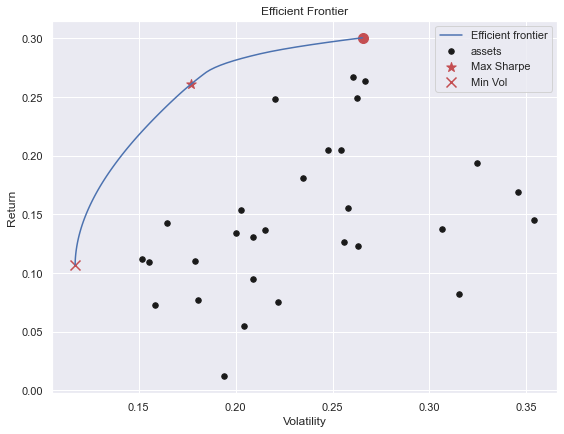

In [8]:
plt.figure(figsize=(8,6))
ef = EfficientFrontier(mu, S)
ax = plot_efficient_frontier(ef)
# Find the tangency portfolio
weights_ms = ef.max_sharpe()
weights_ms = list(weights_ms.values())
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

ef = EfficientFrontier(mu, S)
weights_mv = ef.min_volatility()
weights_mv = list(weights_mv.values())
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="x", s=100, c="r", label="Min Vol")

ef = EfficientFrontier(mu, S)
weights_mr = ef.efficient_risk(0.6) # max return
weights_mr = list(weights_mr.values())
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="o", s=100, c="r")

ax.legend()
ax.set_title('Efficient Frontier')

In [9]:
def portfolio_value(df, weights, starting_value=1000000):
#     weights = list(weights.values())
    # Convert to returns
    rets = pd.Series(df.values@weights).pct_change()
    port_val = rets.add(1).fillna(1).cumprod()*1000000
    return port_val

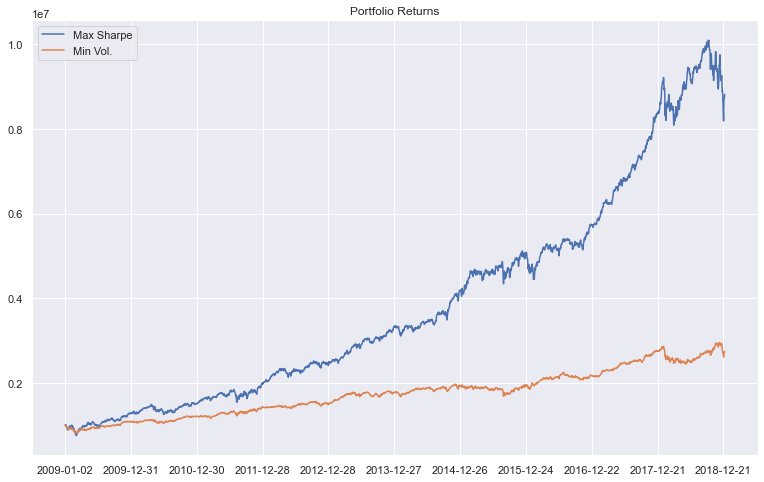

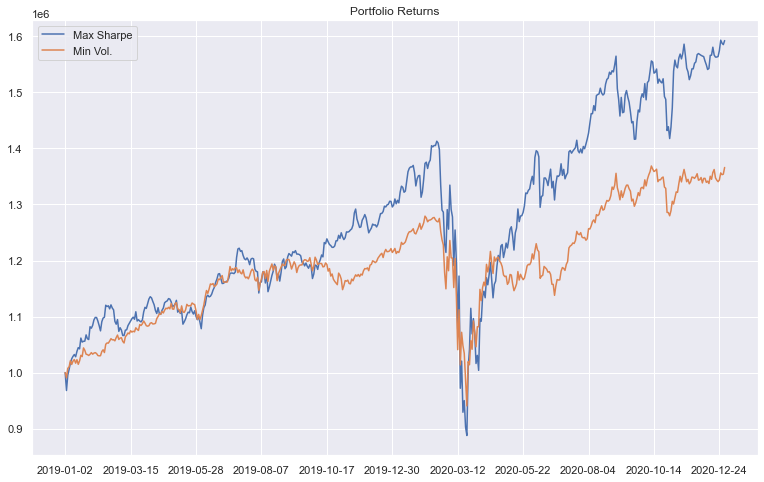

In [10]:
def compare_strategies(df):
    port_value_ms = portfolio_value(df, weights_ms)
    port_value_mv = portfolio_value(df, weights_mv)
    port_value_mr = portfolio_value(df, weights_mr)
    
    ms_df = pd.DataFrame()
    ms_df['Max Sharpe'] = port_value_ms
    ms_df.index = df.index
    plt.plot(port_value_ms, label = 'Max Sharpe')
    plt.plot(port_value_mv, label = 'Min Vol.')
#     plt.plot(port_value_mr, label = 'Max Return')
    plt.title('Portfolio Returns')
    ticks_every_n = int(len(df)/10)
    plt.xticks(ticks=range(0,len(df), ticks_every_n), labels=df.index[::ticks_every_n])
    plt.legend()
    
compare_strategies(train)
plt.show()
compare_strategies(test)

In [18]:
# Get test returns from RL models
returns_a2c = pd.read_csv('daily_returns_a2c.csv', index_col='date')
returns_ddpg = pd.read_csv('daily_returns_ddpg.csv', index_col='date')
returns_ppo = pd.read_csv('daily_returns_ppo.csv', index_col='date')
returns_sac = pd.read_csv('daily_returns_sac.csv', index_col='date')

port_value_a2c = returns_a2c['daily_return'].add(1).fillna(1).cumprod()#*1000000
port_value_ddpg = returns_ddpg['daily_return'].add(1).fillna(1).cumprod()#*1000000
port_value_ppo = returns_ppo['daily_return'].add(1).fillna(1).cumprod()#*1000000
port_value_sac = returns_sac['daily_return'].add(1).fillna(1).cumprod()#*1000000

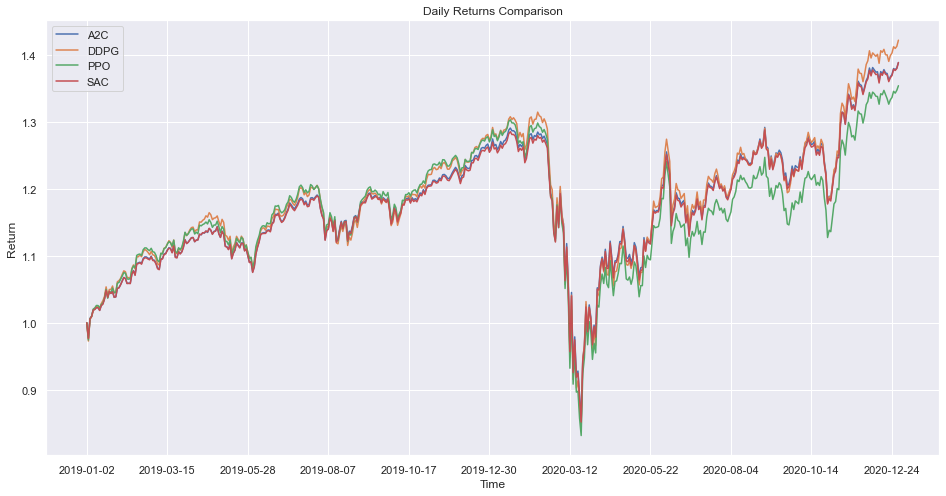

In [19]:
plt.figure(figsize=(16,8))
# compare_strategies(test)
# plt.plot(returns_ddpg.index, baseline_returns.add(1).fillna(1).cumprod()*1000000, label='DJIA')
plt.plot(port_value_a2c, label='A2C')
plt.plot(port_value_ddpg, label='DDPG')
plt.plot(port_value_ppo, label='PPO')
plt.plot(port_value_sac, label='SAC')
ticks_every_n = int(len(returns_ddpg)/10)
plt.xticks(ticks=range(0,len(returns_ddpg), ticks_every_n), labels=returns_ddpg.index[::ticks_every_n])

plt.title('Daily Returns Comparison')
plt.ylabel('Return')
plt.xlabel('Time')
plt.legend()

In [140]:
from pyfolio import timeseries
def get_perf_stats(returns):
    returns['date'] = returns.index
    DRL_strat = convert_daily_return_to_pyfolio_ts(returns)
    perf_func = timeseries.perf_stats 
    perf_stats_all = perf_func(returns=DRL_strat, 
                               factor_returns=None,
                               positions=None, transactions=None, turnover_denom="AGB")
    return perf_stats_all
names = ['DDPG', 'A2C', 'SAC', 'PPO', 'Max Sharpe', 'Min Var', 'DJIA']
stats = []
stats.append(get_perf_stats(returns_ddpg))
stats.append(get_perf_stats(returns_a2c))
stats.append(get_perf_stats(returns_sac))
stats.append(get_perf_stats(returns_ppo))
for s in stats:
    print(s['Sharpe ratio'])
    print()

port_value_ms = pd.DataFrame()
port_value_ms['daily_return'] = (test@weights_ms).pct_change()
port_value_ms.index = returns_ddpg.index
stats.append(get_perf_stats(port_value_ms))

port_value_mv = pd.DataFrame()
port_value_mv['daily_return'] = (test@weights_mv).pct_change()
port_value_mv.index = returns_ddpg.index
stats.append(get_perf_stats(port_value_mv))

weights_ew = list(np.repeat(1/30, 30))
port_val_ew = pd.DataFrame()
port_val_ew['daily_return'] = (test@weights_ew).pct_change()
port_val_ew.index = returns_ddpg.index
stats.append(get_perf_stats(port_val_ew))

0.7716039269747365

0.7663262140409263

0.7655584524223

0.6939297243206828



In [141]:
min(baseline_returns.add(1).fillna(1).cumprod())

0.7963564797095378

In [142]:
rows = []
for row, name in zip(stats, names):
    print(name)
    r = row[['Annual return', 'Annual volatility', 'Sharpe ratio']]
    print(r) #'Max drawdown'
    
    temp = [name]
    [temp.append(q) for q in r.values]
    rows.append(temp)
    print()

DDPG
Annual return        0.191947
Annual volatility    0.277836
Sharpe ratio         0.771604
dtype: float64

A2C
Annual return        0.177929
Annual volatility    0.256931
Sharpe ratio         0.766326
dtype: float64

SAC
Annual return        0.177891
Annual volatility    0.257242
Sharpe ratio         0.765558
dtype: float64

PPO
Annual return        0.163166
Annual volatility    0.270885
Sharpe ratio         0.693930
dtype: float64

Max Sharpe
Annual return        0.261328
Annual volatility    0.302590
Sharpe ratio         0.922477
dtype: float64

Min Var
Annual return        0.168409
Annual volatility    0.208674
Sharpe ratio         0.851946
dtype: float64

DJIA
Annual return        0.148602
Annual volatility    0.275080
Sharpe ratio         0.643246
dtype: float64



In [143]:
rows

[['DDPG', 0.19194667178983438, 0.2778363057704185, 0.7716039269747365],
 ['A2C', 0.17792871530513255, 0.25693088195167424, 0.7663262140409263],
 ['SAC', 0.17789117030057855, 0.2572420619607929, 0.7655584524223],
 ['PPO', 0.16316595872792972, 0.27088539212477347, 0.6939297243206828],
 ['Max Sharpe', 0.2613282553425538, 0.30258986068687155, 0.9224770949961292],
 ['Min Var', 0.16840880414721915, 0.20867395931617605, 0.8519460575568418],
 ['DJIA', 0.1486017062606182, 0.2750797270985892, 0.643246029750489]]

In [144]:
!pip3 install texttable

You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [145]:
from tabulate import tabulate
from texttable import Texttable
print('Tabulate Table:')
print(tabulate(rows, headers=['Annual return', 'Annual volatility', 'Sharpe ratio'],tablefmt='latex'))


Tabulate Table:
\begin{tabular}{lrrr}
\hline
            &   Annual return &   Annual volatility &   Sharpe ratio \\
\hline
 DDPG       &        0.191947 &            0.277836 &       0.771604 \\
 A2C        &        0.177929 &            0.256931 &       0.766326 \\
 SAC        &        0.177891 &            0.257242 &       0.765558 \\
 PPO        &        0.163166 &            0.270885 &       0.69393  \\
 Max Sharpe &        0.261328 &            0.30259  &       0.922477 \\
 Min Var    &        0.168409 &            0.208674 &       0.851946 \\
 DJIA       &        0.148602 &            0.27508  &       0.643246 \\
\hline
\end{tabular}


In [105]:
returns_ddpg['daily_return'].add(1).fillna(1).cumprod()[-1]

1.421727150268748

In [115]:
(port_val_ew['daily_return'].add(1).fillna(1).cumprod()[-1])**(1/2)-1

2.4532579016630823e+83

In [124]:
(test.values.pct_change()@weights_ew).cumprod()

AttributeError: 'numpy.ndarray' object has no attribute 'pct_change'

In [132]:
(test.pct_change().add(1).fillna(1).values@weights_ew).cumprod()[-1]

1.355233780366935

In [22]:
port_val_ew = pd.DataFrame()
port_val_ew['daily_return'] = pd.Series(test.values@weights_ew).pct_change().fillna(0)
# port_val_ew['daily_return'] = port_val_ew['daily_return'].fillna(0).pct_change()
port_val_ew.index = returns_a2c.index
# port_val_ew['date'] = returns_a2c['date']
print(get_perf_stats(port_val_ew))

NameError: name 'weights_ew' is not defined

In [23]:
import pyfolio

baseline_df = get_baseline(
        ticker='^DJI', start='2019-01-01', end='2021-01-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (505, 8)


NameError: name 'DRL_strat' is not defined

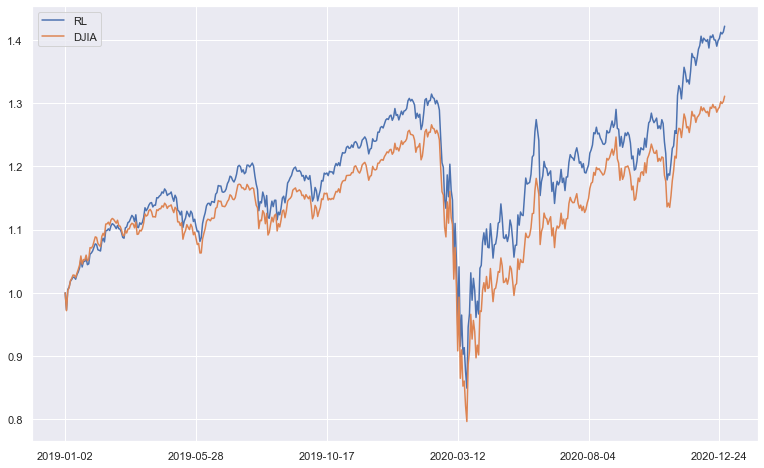

In [254]:
plt.plot(returns_ddpg['daily_return'].add(1).fillna(1).cumprod(), label='RL')
plt.plot(returns_ddpg.index, baseline_returns.add(1).fillna(1).cumprod(), label='DJIA')
plt.xticks(ticks=range(0,len(returns_ddpg), 100))
plt.legend()

In [321]:
weights_ew = list(np.repeat(1/30, 30))
port_val_ew = pd.DataFrame(test.values@weights_ew)
port_val_ew = port_val_ew.pct_change().add(1).fillna(1).cumprod()
port_val_ew.index = returns_ddpg.index

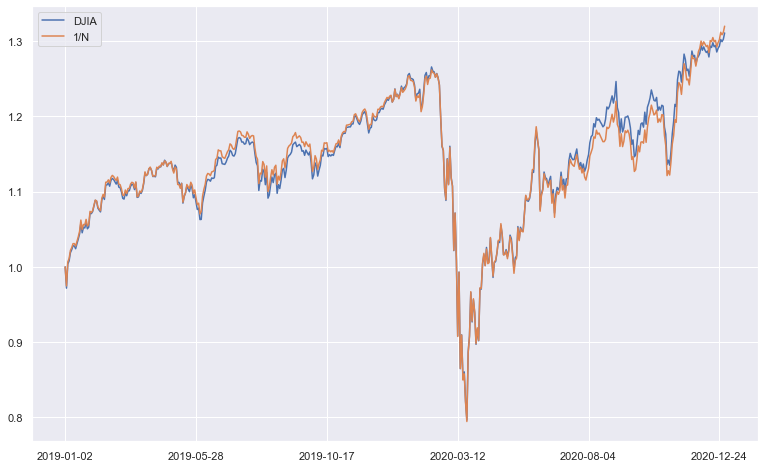

In [324]:
plt.plot(returns_ddpg.index, baseline_returns.add(1).fillna(1).cumprod(), label='DJIA')
plt.plot(port_val_ew, label='1/N')
plt.xticks(ticks=range(0,len(returns_ddpg), 100))
plt.legend()

In [348]:
test.values@weights_ew

array([104.24110527, 101.60729574, 104.93167852, 105.39972153,
       106.51771901, 106.90614421, 107.46019707, 107.47042084,
       107.1170634 , 107.76955846, 108.40205104, 109.16211675,
       110.73103828, 109.42186508, 110.12185809, 110.0636069 ,
       110.82215246, 109.90086314, 110.14671771, 111.93581416,
       111.76852036, 112.04169273, 112.75444514, 113.49670677,
       113.38320936, 112.54318822, 112.26141752, 112.03445524,
       113.73744342, 114.28905398, 113.91220538, 115.97163912,
       115.98723106, 116.29914322, 115.84884249, 116.63295148,
       116.91896795, 116.77060267, 116.4481458 , 116.20068843,
       116.68482819, 115.70004031, 115.63887583, 115.06236509,
       114.18655205, 114.13658129, 114.89589844, 114.39535395,
       115.09457664, 115.11372032, 115.72486038, 115.96456642,
       115.87381516, 115.18419202, 116.02434731, 113.9521375 ,
       114.07199122, 114.75955582, 114.56603991, 114.97913055,
       115.93428485, 117.40935224, 116.89961777, 117.09